In [29]:
# Install scikit-learn, pandas, matplotlib, seaborn, joblib, streamlit, and pyngrok quietly.
!pip install scikit-learn pandas matplotlib seaborn joblib streamlit pyngrok --quiet


In [30]:
# Import pandas for data handling (tables / DataFrames).
import pandas as pd

# Import numpy for numeric operations and array handling.
import numpy as np

# Import matplotlib.pyplot for plotting graphs.
import matplotlib.pyplot as plt

# Import seaborn for statistical visualizations (heatmap, pairplot).
import seaborn as sns

# Import train_test_split to split data into training and testing sets.
from sklearn.model_selection import train_test_split, GridSearchCV

# Import StandardScaler to normalize/scale numeric features.
from sklearn.preprocessing import StandardScaler

# Import pipeline-friendly models: LogisticRegression and RandomForestClassifier.
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Import common evaluation metrics for classification.
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve

# Import joblib for saving and loading trained models.
import joblib

# URL to the Pima Indians Diabetes dataset (raw CSV on GitHub).
# This CSV has columns: Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
data_url = "https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv"

# Read the CSV from the URL into a pandas DataFrame named df.
df = pd.read_csv(data_url)

# Print shape to confirm dataset size (rows, columns).
print("Dataset shape:", df.shape)

# Display first 5 rows to inspect structure.
df.head()


Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


<Figure size 1200x800 with 0 Axes>

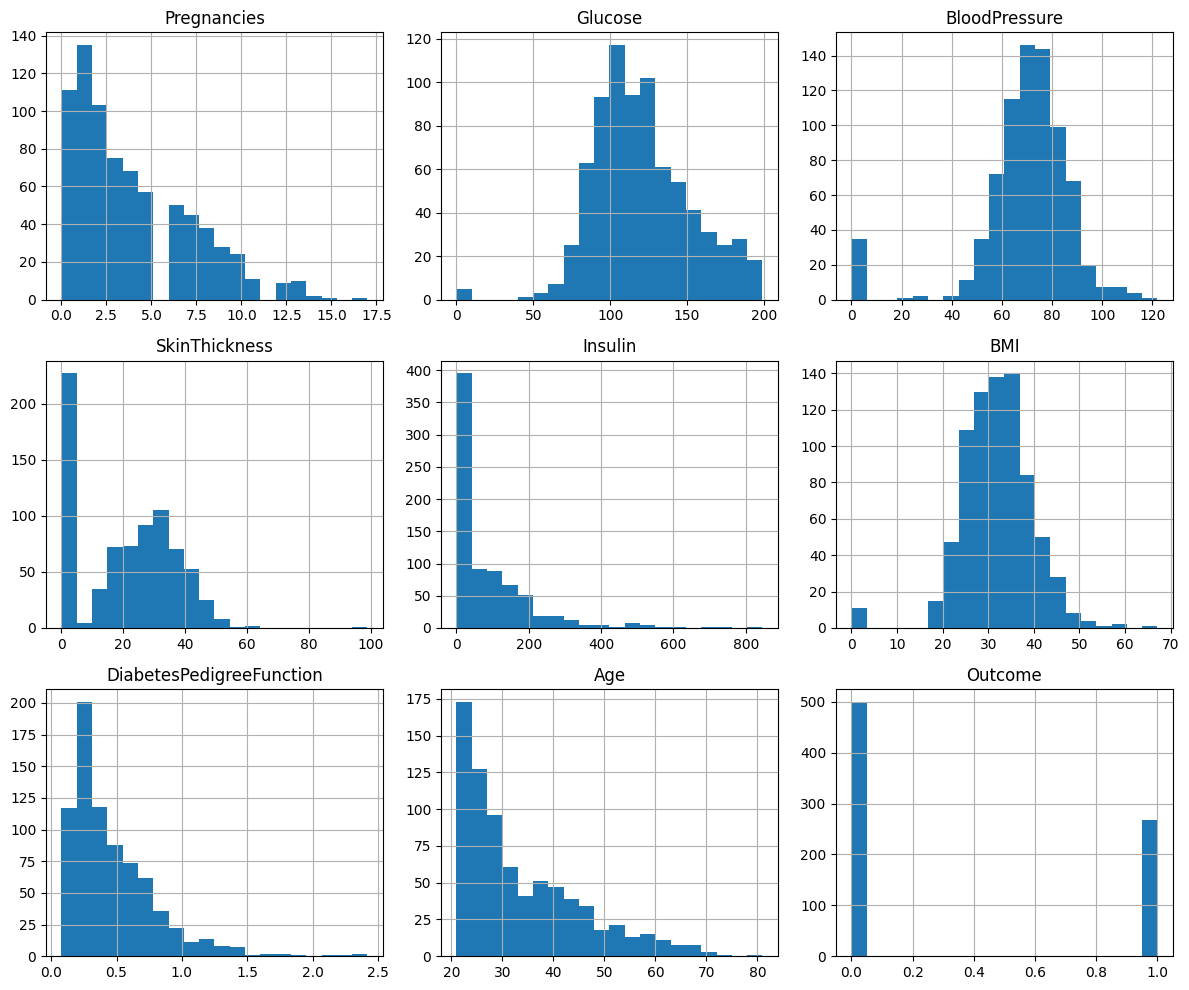

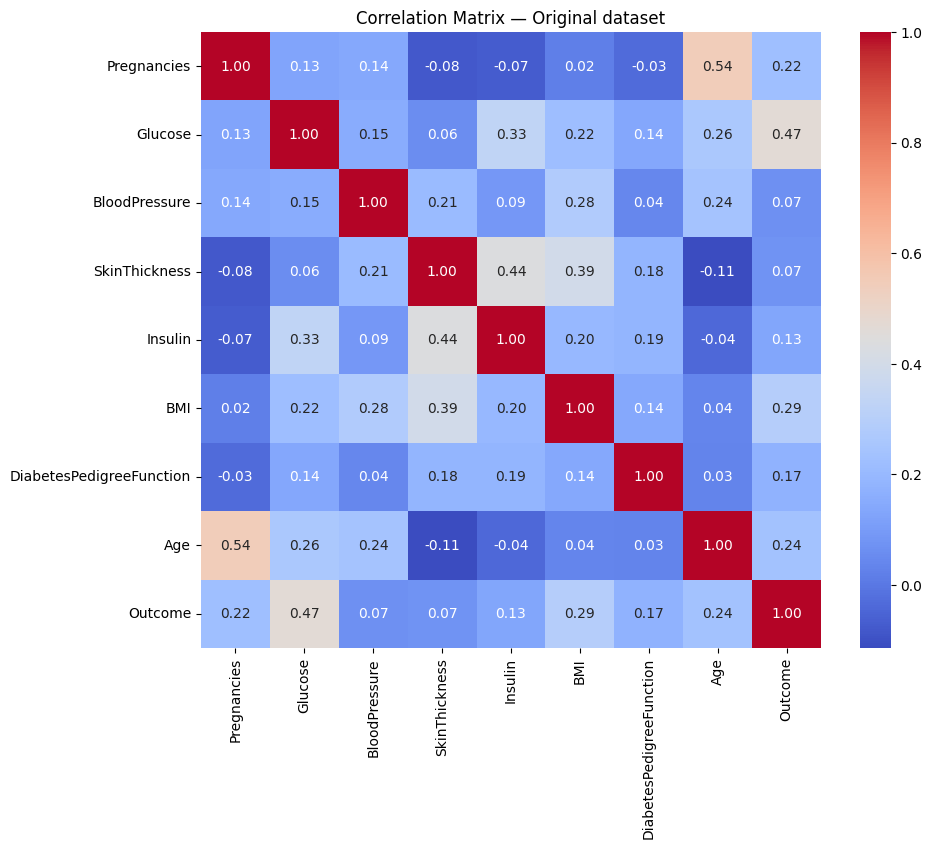

In [31]:
# Show summary statistics (count, mean, std, min, 25%, 50%, 75%, max) for numeric columns.
df.describe()

# Show number of missing / NaN values per column (if any).
df.isnull().sum()

# In this dataset, some values of certain columns (Glucose, BloodPressure, SkinThickness, Insulin, BMI) can be zero — treat zeros as missing for those features.
# Create a copy of df for cleaning steps named df_clean to preserve original.
df_clean = df.copy()

# Define columns where zero indicates missing (domain knowledge for this dataset).
zero_as_missing_cols = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

# For each column in zero_as_missing_cols, replace zeros with np.nan to mark as missing.
for col in zero_as_missing_cols:
    df_clean[col] = df_clean[col].replace(0, np.nan)

# Show count of missing values after replacement to verify.
df_clean[zero_as_missing_cols].isnull().sum()

# Plot histograms for each feature to inspect distributions.
# Set figure size for readability.
plt.figure(figsize=(12, 8))
# Use pandas' hist plotting to draw subplots for all numeric columns.
df.hist(bins=20, figsize=(12,10))
plt.tight_layout()
plt.show()

# Plot a correlation heatmap to see feature relationships.
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix — Original dataset")
plt.show()


In [32]:
# For reproducibility, set a random seed for any randomness later.
RANDOM_STATE = 42

# Use median imputation for missing values in df_clean to avoid bias from outliers.
# Create an imputed copy named df_imputed.
df_imputed = df_clean.copy()

# For each column in zero_as_missing_cols, fill missing values with that column's median.
for col in zero_as_missing_cols:
    df_imputed[col] = df_imputed[col].fillna(df_imputed[col].median())

# Confirm there are no remaining missing values.
print("Missing values after imputation:\n", df_imputed.isnull().sum())

# Feature engineering: create a new BMI_age_interaction feature (BMI multiplied by Age) to capture combined effect.
df_imputed["BMI_age_interaction"] = df_imputed["BMI"] * df_imputed["Age"]

# Create another simple feature: Glucose_per_pregnancy (Glucose divided by (Pregnancies+1)) to avoid division by zero.
df_imputed["Glucose_per_preg"] = df_imputed["Glucose"] / (df_imputed["Pregnancies"] + 1)

# Display first rows of the cleaned & feature-engineered dataset to verify new columns.
df_imputed.head()


Missing values after imputation:
 Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,BMI_age_interaction,Glucose_per_preg
0,6,148.0,72.0,35.0,125.0,33.6,0.627,50,1,1680.0,21.142857
1,1,85.0,66.0,29.0,125.0,26.6,0.351,31,0,824.6,42.500000
2,8,183.0,64.0,29.0,125.0,23.3,0.672,32,1,745.6,20.333333
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0,590.1,44.500000
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1,1422.3,137.000000


In [33]:
# Define the target column name (Outcome where 1 = diabetes, 0 = no diabetes).
target_col = "Outcome"

# Features: all columns except the target.
X = df_imputed.drop(columns=[target_col])

# Labels/target vector y.
y = df_imputed[target_col]

# Split X and y into training and test sets.
# test_size=0.2 for 80/20 split, stratify=y to preserve class ratio, random_state for reproducibility.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)

# Print shapes to confirm split sizes.
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train distribution:\n", y_train.value_counts(normalize=True))
print("y_test distribution:\n", y_test.value_counts(normalize=True))


X_train shape: (614, 10)
X_test shape: (154, 10)
y_train distribution:
 Outcome
0    0.651466
1    0.348534
Name: proportion, dtype: float64
y_test distribution:
 Outcome
0    0.649351
1    0.350649
Name: proportion, dtype: float64


In [34]:
# Initialize StandardScaler instance.
scaler = StandardScaler()

# Fit the scaler on training features and transform training features.
X_train_scaled = scaler.fit_transform(X_train)

# Transform test features using the same scaler (do not fit on test data).
X_test_scaled = scaler.transform(X_test)

# Optionally convert scaled arrays back to DataFrame (preserving column names) for readability.
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)


In [35]:
# Initialize LogisticRegression classifier with a larger max_iter and fixed random state for reproducibility.
log_reg = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)

# Fit the logistic regression model on the scaled training data.
log_reg.fit(X_train_scaled, y_train)

# Predict labels on the scaled test set using the trained logistic regression model.
y_pred_lr = log_reg.predict(X_test_scaled)

# Predict probabilities for the positive class (used for ROC/AUC).
y_prob_lr = log_reg.predict_proba(X_test_scaled)[:, 1]


In [36]:
# Initialize a RandomForestClassifier with a fixed random state.
rf = RandomForestClassifier(random_state=RANDOM_STATE)

# Define a small hyperparameter grid for demonstration. This keeps runtime reasonable in Colab.
param_grid = {
    "n_estimators": [50, 100],
    "max_depth": [None, 6, 10]
}

# Setup GridSearchCV with 3-fold cross-validation, scoring by ROC AUC, and parallel jobs.
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring="roc_auc", n_jobs=-1)

# Fit the grid search on the scaled training data and training labels.
grid_search.fit(X_train_scaled, y_train)

# Extract the best estimator (RandomForest with best hyperparameters).
best_rf = grid_search.best_estimator_

# Predict labels and probabilities on the scaled test set using the tuned RandomForest.
y_pred_rf = best_rf.predict(X_test_scaled)
y_prob_rf = best_rf.predict_proba(X_test_scaled)[:, 1]

# Print best parameters found by GridSearchCV for transparency.
print("Best RandomForest parameters:", grid_search.best_params_)


Best RandomForest parameters: {'max_depth': 6, 'n_estimators': 50}


Logistic Regression — Accuracy: 0.7142857142857143
Logistic Regression — Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.81      0.79       100
           1       0.60      0.54      0.57        54

    accuracy                           0.71       154
   macro avg       0.68      0.67      0.68       154
weighted avg       0.71      0.71      0.71       154

Logistic Regression — Confusion Matrix:
 [[81 19]
 [25 29]]
Logistic Regression — ROC AUC: 0.8072222222222222


Random Forest — Accuracy: 0.7467532467532467
Random Forest — Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.85      0.81       100
           1       0.67      0.56      0.61        54

    accuracy                           0.75       154
   macro avg       0.72      0.70      0.71       154
weighted avg       0.74      0.75      0.74       154

Random Forest — Confusion Matrix:
 [[85 15]
 [24 30]

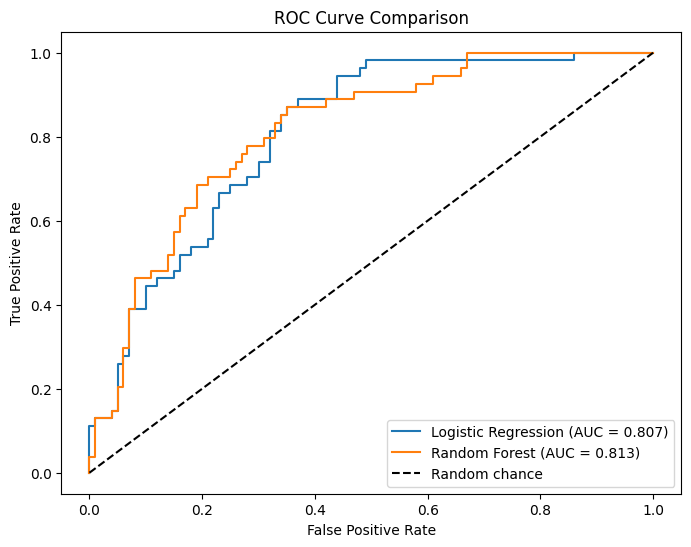

In [37]:
# Evaluate Logistic Regression: accuracy, classification report, confusion matrix, ROC AUC.
print("Logistic Regression — Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Logistic Regression — Classification Report:\n", classification_report(y_test, y_pred_lr))
print("Logistic Regression — Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))
print("Logistic Regression — ROC AUC:", roc_auc_score(y_test, y_prob_lr))

# Add a blank line for readability.
print("\n")

# Evaluate Random Forest: same metrics.
print("Random Forest — Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest — Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Random Forest — Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Random Forest — ROC AUC:", roc_auc_score(y_test, y_prob_rf))

# Plot ROC curves for both models to compare visually.
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

plt.figure(figsize=(8,6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, y_prob_lr):.3f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_prob_rf):.3f})')
plt.plot([0,1], [0,1], 'k--', label='Random chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()


In [38]:
# Decide which model to save: choose best_rf if its ROC AUC >= logistic ROC AUC, else use log_reg.
if roc_auc_score(y_test, y_prob_rf) >= roc_auc_score(y_test, y_prob_lr):
    model_to_save = best_rf
    chosen = "RandomForest"
else:
    model_to_save = log_reg
    chosen = "LogisticRegression"

# Print which model we will save.
print(f"Saving chosen model: {chosen}")

# Save the chosen model to disk as 'diabetes_model.pkl'.
joblib.dump(model_to_save, "diabetes_model.pkl")

# Save the fitted scaler to disk as 'scaler.pkl' (we fitted it earlier on training data).
joblib.dump(scaler, "scaler.pkl")

# Confirm files saved.
print("Saved files: diabetes_model.pkl, scaler.pkl")


Saving chosen model: RandomForest
Saved files: diabetes_model.pkl, scaler.pkl


In [39]:
# --- Save feature columns list (needed by Streamlit app) ---

# The model was trained on these columns
feature_cols = [
    "Pregnancies",
    "Glucose",
    "BloodPressure",
    "SkinThickness",
    "Insulin",
    "BMI",
    "DiabetesPedigreeFunction",
    "Age",
    "BMI_age_interaction",
    "Glucose_per_preg"
]

# Save the feature column list so the app knows the expected order.
joblib.dump(feature_cols, "feature_columns.pkl")

print("Saved: diabetes_model.pkl, scaler.pkl, feature_columns.pkl ✅")


Saved: diabetes_model.pkl, scaler.pkl, feature_columns.pkl ✅
Saved: diabetes_model.pkl, scaler.pkl, feature_columns.pkl ✅


In [48]:
# Write this Streamlit app into a file named "app.py"
%%writefile app.py

# Import the Streamlit library for creating web apps interactively
import streamlit as st

# Import NumPy for numerical operations and arrays
import numpy as np

# Import pandas for handling tabular data (DataFrames)
import pandas as pd

# Import joblib for loading the pre-trained ML model and scaler
import joblib

# Import Plotly Graph Objects for custom visualizations (like gauge charts)
import plotly.graph_objects as go

# Import Plotly Express for quick, simple charts (like scatter plots)
import plotly.express as px


# ---------------- PAGE CONFIG ----------------
# Configure Streamlit page — sets the title, icon, and layout of the app
st.set_page_config(page_title="Diabetes Prediction", page_icon="🩺", layout="centered")


# ---------------- TITLE & INTRO ----------------
# Display the main title of the web app
st.title(" Diabetes Prediction App")

# Write a short introduction about the app
st.write("""
This app predicts whether a person is **likely to have diabetes** based on key health parameters.
""")


# ---------------- LOAD MODEL & SCALER ----------------
# Load the StandardScaler that was fitted during model training
scaler = joblib.load("scaler.pkl")

# Load the trained Machine Learning model (Random Forest or Logistic Regression)
model = joblib.load("diabetes_model.pkl")

# Load the expected column order used by the model to ensure correct input order
expected_cols = joblib.load("feature_columns.pkl")


# Function to style input status (Low / Normal / High)
def color_status(value, low, high):
    """Return colored label for safe/risky values."""
    # If input value is lower than safe range
    if value < low:
        return f"🟡 Low"
    # If input value is higher than safe range
    elif value > high:
        return f"🔴 High"
    # If input value is within the safe range
    else:
        return f"🟢 Normal"


# ---------------- INPUT SECTION ----------------
# Header for the input section where user provides health details
st.header(" Enter Patient Details")


# Gender input: choose Male or Female from dropdown
gender = st.selectbox(
    "Gender",
    ["Female", "Male"],
    help="Select patient gender. Male patients have pregnancies automatically set to 0.")


# Pregnancies input: only shown for females
if gender == "Female":
    # Number input for pregnancies (0 to 20)
    pregnancies = st.number_input("Pregnancies", 0, 20, 0, help="Number of times the patient has been pregnant.")
else:
    # Automatically set to 0 for males since not applicable
    pregnancies = 0


# Glucose input field (blood sugar level)
glucose = st.number_input("Glucose (mg/dL)", 0.0, 300.0, 120.0, help="Plasma glucose concentration after 2 hours in an oral glucose tolerance test.")
# Display status feedback (Low / Normal / High) for glucose
st.markdown(f"**Status:** {color_status(glucose, 70, 130)} (Normal: 70–130 mg/dL, Risky >180)")


# Blood Pressure input field
blood_pressure = st.number_input("Blood Pressure (mm Hg)", 0.0, 200.0, 70.0, help="Diastolic blood pressure in millimeters of mercury (mm Hg).")
# Display status feedback for blood pressure
st.markdown(f"**Status:** {color_status(blood_pressure, 60, 80)} (Normal: 60–80 mm Hg)")


# Skin Thickness input field (triceps fold thickness)
skin_thickness = st.number_input("Skin Thickness (mm)", 0.0, 100.0, 20.0, help="Triceps skin fold thickness – an indicator of body fat.")
# Display status feedback for skin thickness
st.markdown(f"**Status:** {color_status(skin_thickness, 10, 40)} (Healthy range: 10–40 mm)")


# Insulin level input field
insulin = st.number_input("Insulin (mu U/ml)", 0.0, 1000.0, 80.0, help="2-Hour serum insulin level – higher values may indicate insulin resistance.")
# Display status feedback for insulin
st.markdown(f"**Status:** {color_status(insulin, 16, 166)} (Normal: 16–166 mu U/ml)")


# BMI (Body Mass Index) input field
bmi = st.number_input("BMI (Body Mass Index)", 0.0, 100.0, 25.0, help="Body Mass Index = weight (kg) / height (m)² – indicator of body fatness.")
# Display status feedback for BMI
st.markdown(f"**Status:** {color_status(bmi, 18.5, 24.9)} (Normal: 18.5–24.9)")


# Diabetes Pedigree Function input field (genetic risk)
dpf = st.number_input("Diabetes Pedigree Function", 0.0, 5.0, 0.5, help="Score indicating genetic risk based on family history.")
# Display status feedback for DPF
st.markdown(f"**Status:** {color_status(dpf, 0.0, 0.8)} (Higher = higher genetic risk)")


# Age input field
age = st.number_input("Age (years)", 1, 120, 33, help="Age of the patient in years.")
# Display status feedback for age
st.markdown(f"**Status:** {color_status(age, 18, 45)} (Risk increases after 45 years)")


# ---------------- FEATURE ENGINEERING ----------------
# Create an interaction feature combining BMI and Age
bmi_age_interaction = bmi * age

# Create glucose per pregnancy (avoid divide by zero)
glucose_per_preg = glucose / (pregnancies + 1)

# Encode gender numerically (Male = 1, Female = 0)
gender_encoded = 1 if gender == "Male" else 0

# Combine all inputs into a DataFrame (1 row of patient data)
input_df = pd.DataFrame([{
    "Gender": gender_encoded,
    "Pregnancies": pregnancies,
    "Glucose": glucose,
    "BloodPressure": blood_pressure,
    "SkinThickness": skin_thickness,
    "Insulin": insulin,
    "BMI": bmi,
    "DiabetesPedigreeFunction": dpf,
    "Age": age,
    "BMI_age_interaction": bmi_age_interaction,
    "Glucose_per_preg": glucose_per_preg
}])[expected_cols]  # Ensure correct column order


# Scale the input data using the same scaler from training
input_scaled = scaler.transform(input_df)


# ---------------- PREDICTION ----------------
# Create a Predict button that runs model inference when clicked
if st.button("🔍 Predict"):
    # Get the probability of the positive class (diabetes)
    proba = model.predict_proba(input_scaled)[0][1]

    # Get the predicted class label (0 = non-diabetic, 1 = diabetic)
    pred = model.predict(input_scaled)[0]

    # Convert probability to percentage with one decimal
    confidence = round(proba * 100, 1)

    # Display subheader for prediction output
    st.subheader(" Prediction Result")

    # If model predicts diabetic, show red alert
    if pred == 1:
        st.error(f"⚠️ The patient is **likely diabetic** with {confidence}% confidence.")
    # Otherwise, show green success message
    else:
        st.success(f" The patient is **likely non-diabetic** with {confidence}% confidence.")


    # ---------------- VISUAL 1: GAUGE ----------------
    # Choose gauge color (red for diabetic, green for normal)
    gauge_color = "red" if pred == 1 else "green"

    # Create a gauge chart showing diabetes probability
    fig_gauge = go.Figure(go.Indicator(
        mode="gauge+number",  # Show dial + numeric value
        value=confidence,  # Display predicted probability
        title={"text": "Diabetes Probability (%)"},  # Chart title
        gauge={
            "axis": {"range": [0, 100]},  # Gauge scale from 0 to 100
            "bar": {"color": gauge_color},  # Color of indicator
            "steps": [  # Background color sections
                {"range": [0, 40], "color": "lightgreen"},
                {"range": [40, 70], "color": "yellow"},
                {"range": [70, 100], "color": "lightcoral"},
            ],
        },
    ))
    # Display gauge chart in Streamlit app
    st.plotly_chart(fig_gauge, use_container_width=True)


    # ---------------- VISUAL 2: BMI vs Glucose ----------------
    # Subheader for the scatter chart
    st.subheader(" Visual Insight — BMI vs Glucose")

    # Set seed for reproducible random points
    np.random.seed(42)

    # Generate random sample BMI and Glucose values
    sample_data = pd.DataFrame({
        "BMI": np.random.uniform(15, 45, 50),
        "Glucose": np.random.uniform(70, 200, 50)
    })

    # Label half as Normal, half as High Risk
    sample_data["Condition"] = ["Normal"]*25 + ["High Risk"]*25

    # Create scatter plot showing normal vs risky zones
    fig_scatter = px.scatter(
        sample_data, x="BMI", y="Glucose",
        color="Condition",
        color_discrete_map={"Normal": "green", "High Risk": "red"},
        title="BMI vs Glucose — Risk Zones")

    # Add the user’s point to the scatter plot
    fig_scatter.add_trace(go.Scatter(
        x=[bmi], y=[glucose],
        mode="markers+text",  # Marker + label text
        marker=dict(color=gauge_color, size=12, line=dict(color="black", width=1)),
        text=["You"],  # Label for user input
        textposition="top center",
        name="Your Input"
    ))

    # Display scatter chart in app
    st.plotly_chart(fig_scatter, use_container_width=True)


    # ---------------- DISCLAIMER ----------------
    # Display medical disclaimer note at the end
    st.info("⚠️ *This result is a machine learning-based estimate. Always consult a medical professional for official diagnosis.*")








Overwriting app.py


In [49]:
# Import ngrok to create a public tunnel to localhost.
from pyngrok import ngrok

# Import time (for waiting) and os (to run commands).
import time, os

# Replace this with your personal ngrok token.
NGROK_AUTHTOKEN = "3536tjxZzkcNAbMjjVIegi0rOA9_4QgBc7uxDJWnwaxFDtsnq"

# Set the ngrok authentication token (enables access to tunnels).
ngrok.set_auth_token(NGROK_AUTHTOKEN)

# Kill any old ngrok tunnels that might still be running.
ngrok.kill()

# Run the Streamlit app in the background on port 8501.
os.system("streamlit run app.py --server.port 8501 &")

# Wait a few seconds to let Streamlit start properly.
time.sleep(8)

# Create a new ngrok tunnel to port 8501 and store the returned URL.
public_url = ngrok.connect(8501)

# Print a message with the live app URL for easy access.
print("Your Heart Disease Prediction App is live at:")
print(public_url)

Your Heart Disease Prediction App is live at:
NgrokTunnel: "https://willetta-postorbital-amberly.ngrok-free.dev" -> "http://localhost:8501"
